In [1]:
%matplotlib inline
import random
import scipy
from scipy.stats import linregress
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc, colors

# Random model

## Random boolean functions over N bits (e.g. N functional traits)

In this section we study numerically the redundancy of random boolean functions $E^*$ over N bits, i.e.
$$
E^*:\{0,1\}^N \rightarrow \{0,1\}
$$
Redundancy is defined as the number of bit flips (starting from all bits=1) before the function changes its output from 1 to 0. We will show that, over a uniform random choice of function $E^*$ over the set of all possible functions, it typically only takes two bitflips before failure (so very low redundancy).  

In [2]:
def f(N,ntrials): #number of bitflips before failure (redundancy) of a random boolean function over N bits
    lst=[]
    dic={tuple([0]):0}               #make a dictionary for the random function, filling it up along the way 
    for trial in range(ntrials):     #loop over random trait extinction scenarios
        idx=2**N-1                   #start from the top 
        extinctions=0
        traits=list(np.arange(0,N))
        f=1
        while f==1:
            extinctions+=1
            idx=idx-2**traits.pop(np.random.randint(0,len(traits))) #remove a trait at random
            if tuple([idx]) in dic:
                f=dic[tuple([idx])]
            else:
                f=np.random.randint(0,2)
                dic[tuple([idx])]=f
        lst.append(extinctions)      #number of extinctions needed before f=0
    return lst 

In [3]:
#Effect of number bits on the redundancy of random boolean functions
n=0
E5=[]
E10=[]
E50=[]
while n<=500:
    n+=1
    E5=np.concatenate([E5,[np.mean(f(5,ntrials=100))]])      #N=5
    E10=np.concatenate([E10,[np.mean(f(10,ntrials=200))]])   #N=10
    E50=np.concatenate([E50,[np.mean(f(50,ntrials=500))]])   #N=50

Text(0.5,0,'redundancy')

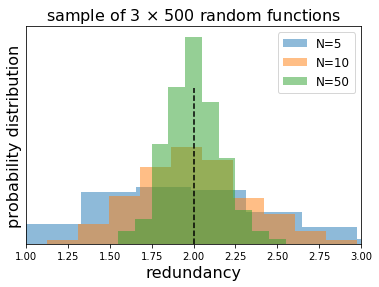

In [4]:
plt.hist(E5,density=1,bins=10,alpha=.5)#,histtype='step',linewidth=2);
plt.hist(E10,density=1,bins=10,alpha=.5)#,histtype='step',linewidth=2);
plt.hist(E50,density=1,bins=10,alpha=.5)#,histtype='step',linewidth=2);
#
plt.title(r'sample of 3 $\times$ 500 random functions', fontsize=16)
plt.xlim(1,3)
plt.legend(['N=5','N=10','N=50'],fontsize=12)
plt.plot([2,2],[0,2],'k--')
plt.yticks([])
plt.ylabel('probability distribution',fontsize=16)
plt.xlabel('redundancy',fontsize=16)

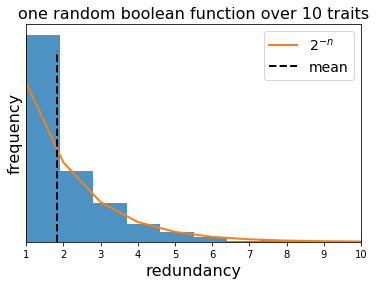

In [5]:
N=10
lst=f(N,1000)
plt.hist(lst,density=1,bins=10,alpha=0.8)
xs=np.arange(0,11,1)[1:]
plt.plot(xs,2.**(-xs),lw=2,label='$2^{-n}$') #[poisson.pmf(x,1) for x in xs[:-1] ]
plt.plot([np.mean(lst),np.mean(lst)],[0,0.6],'--k',lw=2,label='mean')
plt.xlim(1,N)
plt.yticks([])
plt.title('one random boolean function over 10 traits', fontsize=16)
plt.xlabel('redundancy', fontsize=16)
plt.ylabel('frequency',fontsize=16)
plt.legend(fontsize=14)

# Random model of ecosystem services

Ecosystem services are seen as boolean functions $E$ over $S$ bits (the species) that can be decomposed as 
$$E= E^* \circ OR^N;\;E^*:\{0,1\}^N \rightarrow \{0,1\}$$
where $E^*$ is the auxilliary boolean function over $N$ bits (the functional traits) while 
$$OR^N=OR_1 \times ... \times OR_N : \{0,1\}^S \rightarrow \{0,1\}^N$$
is the product of $N$ OR-functions over the species that share the same functional trait. We will consider  two choices for $E^*$. Either the AND function (the least redundant function), or a random function sampled uniformlly over the space of all boolean functions over $N$ bits.  

In [6]:
#Theoretical fragility of a random Sspecies-Ntrait network
def Arand(N,S,p,c1,c2):
    A=(np.random.random(size=(N,S))>1-p).astype("int")
    absent=np.where(np.max(A,axis=1)==0)[0]
    add=np.random.randint(0,S,size=len(absent))
    A[absent,add]=1
    phat=np.sum(A)/(N*S*1.)
    q=1-phat
    f_c1=np.log(1.-(1.-q**S)*np.power(c1,1./N))/S/np.log(q)
    f_c2=np.log(1.-(1.-q**S)*np.power(c2,1./N))/S/np.log(q)
    f_05=np.log(1.-(1.-q**S)*np.power(0.5,1./N))/S/np.log(q)
    return A,f_c1,f_05,f_c2

# Figure 1a ($E^*=AND$)

In [9]:
#Generating extinction sequences for random ecosystem services.

c1=0.25 #percentiles of interest
c2=0.75

#nework fragility
F25=[]
F50=[]
F75=[]

#robustness in fully random model
Rob25=[]
Rob50=[]
Rob75=[]

#robustness in simplified model
Rob_AND25=[]
Rob_AND50=[]
Rob_AND75=[]

#random sampling of 5x5x5 ecosystem services 
NN=np.random.randint(10,100,size=5)
SS=np.random.randint(10,200,size=5)
pp=np.random.uniform(0.01,0.5,size=5)

for N in NN:
    print "N=", N
    for S in SS:
        for p in pp:
            A,per1,median,per2=Arand(N,S,p,c1,c2)
            
            F25=np.concatenate([F25,[per2]])
            F50=np.concatenate([F50,[median]])
            F75=np.concatenate([F75,[per1]])
            
            #Fhat=np.concatenate([Fhat,[fhat]])
            ntrials=600
            one=np.ones(N).astype("int")
            zero=np.zeros(N).astype("int")
            dic={tuple(one):1}
            dic[tuple(zero)]=0
            dic_AND={tuple(one):1}
            dic_AND[tuple(zero)]=0
           
            r=[]
            r_AND=[]
            for k in range(ntrials):
                species=np.random.permutation(S)
                Aperm=A[:,species]
                
                #RANDOM CHOICE                    #fully random model E*=random
                n=0
                f=1
                while (f==1)&(n<S):                
                    lst=np.max(Aperm[:,n:],axis=1)
                    w=tuple(lst)
                    if w in dic:
                        f=dic[w]
                    else:
                        f=np.random.randint(0,2)
                        dic[w]=f
                    n=n+1
                #E*=AND                         #simplified random model E*=AND
                m=0
                fand=1
                while (fand==1)&(m<S):                
                    lst=np.max(Aperm[:,m:],axis=1)
                    w=tuple(lst)
                    if w in dic_AND:
                        fand=dic_AND[w]
                    else:
                        fand=0
                    m=m+1
                r=np.concatenate([r,[(n*1.)/(1.*S)]])
                r_AND=np.concatenate([r_AND,[(m*1.)/(1.*S)]])
            
                        
            Rob25=np.concatenate([Rob25,[np.percentile(r,25)]])
            Rob50=np.concatenate([Rob50,[np.median(r)]])
            Rob75=np.concatenate([Rob75,[np.percentile(r,75)]])
            
            Rob_AND25=np.concatenate([Rob_AND25,[np.percentile(r_AND,25)]])
            Rob_AND50=np.concatenate([Rob_AND50,[np.median(r_AND)]])
            Rob_AND75=np.concatenate([Rob_AND75,[np.percentile(r_AND,75)]])

99
80
56
25
46


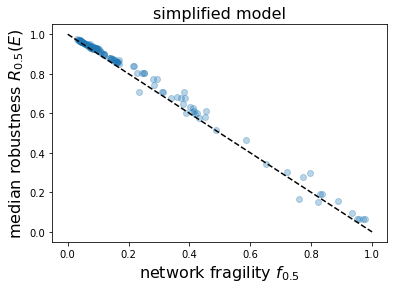

In [10]:
#Figure 2 (a)
plt.scatter(F50,Rob_AND50, alpha=0.3,label=('$E^*\equiv \mathrm{AND}$'))
plt.xlabel('network fragility $f_{0.5}$',fontsize=16)
plt.ylabel('median robustness $R_{0.5}(E)$',fontsize=16)
plt.title('simplified model', fontsize=16)
x=np.linspace(0,1)
plt.plot(x,1-x,'k--')

# Comparison with the fully random model ($E^* $ is random instead of $E^*=AND$) (Figure S2)

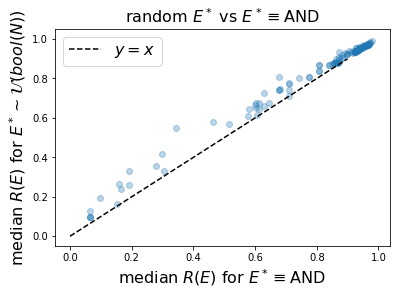

In [12]:
plt.scatter(Rob_AND50,Rob50, alpha=0.3) #
plt.xlabel(r'$ \mathrm{median} \;  R(E)$ for $E^*\equiv \mathrm{AND}$',fontsize=16)
plt.ylabel(r'$ \mathrm{median} \; R(E)$ for $E^* \sim \mathcal{U}(bool(N))$',fontsize=16)
plt.title('random $E^*$ vs $E^*\equiv \mathrm{AND}$', fontsize=16)
x=np.linspace(0,0.9)
plt.plot(x,x,'k--',label=('$y=x$'))
plt.legend(fontsize=16)

# Figure 2b: width of robustness in the simplified model as a function of fragility

4
16
128


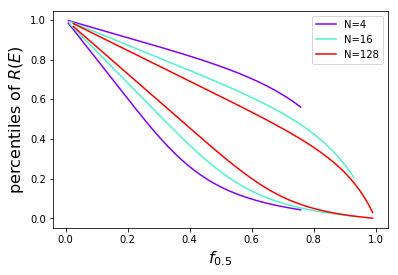

In [8]:
#Figure 2
c1=0.1
c2=0.9

NN=[4,16,128]

cmap = plt.cm.rainbow
norm = colors.Normalize(vmin=min(np.log2(NN)), vmax=max(np.log2(NN)))


SS=np.random.randint(5,1000,size=20)
pp=np.random.uniform(0.0,0.2,size=100)
for N in NN:
    F25=[]
    F50=[]
    F75=[]
    print N
    for S in SS:
        for p in pp:
            A,per1,median,per2=Arand(N,S,p,c1,c2)
            
            F25=np.concatenate([F25,[per2]])
            F50=np.concatenate([F50,[median]])
            F75=np.concatenate([F75,[per1]])
            
    index=np.argsort(F50)
    plt.plot(F50[index],1-F25[index],color=cmap(norm(np.log2(N))),label=('N={}'.format(N)))
    plt.plot(F50[index],1-F75[index],color=cmap(norm(np.log2(N))))

plt.xlabel('$f_{0.5}$', fontsize=16)
plt.ylabel('percentiles of $R(E)$',fontsize=16)
plt.legend()